In [1]:
import numpy as np
import cv2
import scipy
import math
import matplotlib.pyplot as plt
from Utils.MathUtils import *
from Utils.ImageUtils import *
from Utils.MiscUtils import *
from Utils.KalmanFilter import *
from Utils.MovingAverage import *

import csv 

K = np.array([[1406.08415449821, 0, 0], [2.20679787308599, 1417.99930662800, 0], [1014.13643417416, 566.347754321696, 1]])
K = np.transpose(K)

In [2]:
def findContour(image):
    
    ret,thresh = cv2.threshold(np.uint8(image), 200 ,255,cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    chosen_contours = []

    previous_area = cv2.contourArea(contours[0])
    for j in range(len(contours)):
        if hierarchy[0, j, 3] == -1:#no parent
            if hierarchy[0, j, 2] !=-1: #child
                #print("no parent, child present")
                area = cv2.contourArea(contours[j])
                if True: #np.abs(area - previous_area) < 1000:
                    chosen_contours.append(contours[j])
                    previous_area = area

    return chosen_contours

In [3]:
def getTagMask(image):
    
    image_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.GaussianBlur(image_gray, (21, 21), 0)

    chosen_contours = findContour(image_gray)
    out_mask = np.zeros_like(image_gray)
    corners = []
    for chosen_contour in chosen_contours:
        corner = cv2.approxPolyDP(chosen_contour, 0.009 * cv2.arcLength(chosen_contour, True), True)
        corners.append(corner.reshape(-1,2))
        cv2.drawContours(out_mask, [chosen_contour], -1, 1, cv2.FILLED)  

    out_mask_mul = np.dstack((out_mask, out_mask, out_mask))
    detected_april_tag = image_rgb * out_mask_mul
    return detected_april_tag


In [4]:
def getTagCorners(image):

    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image_gray = cv2.medianBlur(image_gray, 3)

    (T, thresh) = cv2.threshold(image_gray, 180, 255, cv2.THRESH_BINARY)
    kernel = np.ones((5,5), np.uint8)
    # thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    contours, hierarchy=cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    ctr=[]
    if hierarchy is not None:
        for j, cnt in zip(hierarchy[0], contours):
            cnt_len = cv2.arcLength(cnt,True)
            cnt = cv2.approxPolyDP(cnt, 0.02*cnt_len,True)
            # ctr.append(cnt)

            if cv2.isContourConvex(cnt) and len(cnt) == 4 and cv2.contourArea(cnt) > 500 :
                cnt=cnt.reshape(-1,2)
                #if j[0] == -1 and j[1] == -1 and j[3] != -1:
                if j[2] != -1 and j[3] != -1:
                    ctr.append(cnt)
    return ctr


In [5]:
def drawCube(image, bottom_points, top_points):

    cv2.drawContours(image, [bottom_points], 0, (255, 0 ,255),3)
    cv2.drawContours(image, [top_points], 0, (255, 0, 255),3)

    for i in range(0, bottom_points.shape[0]):
        color = (int(255/(i+1)), 0, int(255/(i+1)))
        cv2.line(image, (bottom_points[i,0], bottom_points[i,1]), (top_points[i,0], top_points[i,1]), color, 3)

    return image


In [21]:
BasePath = '/home/sakshi/courses/ENPM673/sakshi_p1/'
video_file = BasePath + "Data/Tag2.mp4"
SaveFileName = BasePath +"/Results/problem2/testudo/Tag2_unfiltered.avi"
cap = cv2.VideoCapture(video_file)
frame_width = int(cap.get(3)) 
frame_height = int(cap.get(4))
result = cv2.VideoWriter(SaveFileName,  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         10, (frame_width, frame_height)) 

f = open("corners.csv", 'w')
csvwriter = csv.writer(f)  

ff = open("cornersf.csv", 'w')
csvwriterf = csv.writer(ff)  


testudoFileName = BasePath + "Data/testudo.jpg"
testudo_image = cv2.imread(testudoFileName)
if testudo_image is None:
    print("testudo image no found!")


testudo_x = testudo_image.shape[1]
testudo_y = testudo_image.shape[0]
testudo_corners = np.array([[0,0], [0, testudo_y-1], [testudo_x-1, testudo_y-1], [testudo_x-1, 0]])
testudo_corners = sortCorners(testudo_corners)

count = 0
number_of_tags = 1
chosen_frame = 0
chosen_corners = 0
rotation = 0 

tag_size = 160
desired_tag_corner = sortCorners(np.array([ [0, tag_size-1], [tag_size-1, tag_size-1], [tag_size-1, 0], [0, 0]]))

first_time = True
project_testudo = True
use_filter = False
window_size_base = 4
window_size_top = 5

if use_filter:
    print("APPLYING FILTER TO  POINTS OF CUBE")
    fps = cap.get(cv2.CAP_PROP_FPS)
    dt = 1/fps

while(True):
    
    ret, frame = cap.read()
    if not ret:
        print("Stream ended..")
        break
    
    image_rgb = frame
    rows,cols,ch = image_rgb.shape
    
    detected_april_tag = np.uint8(getTagMask(image_rgb)) #without white paper

    if first_time:
        old_corners = getTagCorners(detected_april_tag)
        number_of_tags = len(old_corners)
        maBase = MovingAverage(window_size_base, 10)
        maTop = MovingAverage(window_size_top, 5)


    corners = getTagCorners(detected_april_tag)
    if count == 3:
        chosen_frame = image_rgb
        chosen_corners = corners


    if(len(corners) < 1):
        corners = old_corners
    else:
        old_corners = corners

    # cv2.drawContours(detected_april_tag, corners,0,(0,255,0),5)
    # if len(corners) > 3:
    #     print(len(corners))
    # for corner in corners:
    #     cv2.drawContours(detected_april_tag, [corner], 0, (0,255,0), 3)
    image_show = image_rgb.copy()
    for corner in corners:
        set1 = testudo_corners
        set2 = sortCorners(corner)

        if use_filter:
            if maBase.getListLength() <  window_size_base:
                maBase.addQuadrilateral(set2)
            else:
                maBase.addQuadrilateral(set2)
                set2 = maBase.getAverage().astype(int)
                # cv2.drawContours(image_rgb, [set2_filtered], 0, (255, 255, 0), 5)

        Htd = computeHomography(np.float32(set2), np.float32(desired_tag_corner))

        tag = applyHomography2ImageUsingInverseWarping(image_rgb, Htd, (tag_size, tag_size))
        tag = cv2.cvtColor(np.uint8(tag), cv2.COLOR_BGR2GRAY)
        ret,tag = cv2.threshold(np.uint8(tag), 230 ,255,cv2.THRESH_BINARY)

        tag_info = extractInfoFromTag(tag)
        ARcorners = np.array([tag_info[0,0], tag_info[0,3], tag_info[3,0], tag_info[3,3]])

        rotation = 0 
        if np.sum(ARcorners) == 255:
            while not tag_info[3,3]:
                tag_info = np.rot90(tag_info, 1)
                rotation = rotation + 90

            if first_time:
                old_rotation = rotation

            
            del_rotation = np.minimum(np.abs(old_rotation - rotation), np.abs(old_rotation - rotation - 360))
            if (del_rotation > 100): #basically, greater than 90
                print("del rotation high")
                # rotation = old_rotation

            old_rotation = rotation
        else:
            print("Tag not detected properly!")
            rotation = old_rotation

        # print("rotation = ", rotation)
        num_rotations = int(rotation/90)
        for n in range(num_rotations):
            set2 = rotatePoints(set2)
            # desired_tag_corner = rotatePoints(desired_tag_corner)


        if project_testudo:
            H12 = computeHomography(set1, set2)
            set1_trans = applyHomography2Points(set1, H12)
            cv2.drawContours(detected_april_tag, [set1_trans], 0, (0,255,255),3)
            testudo_transormed = applyHomography2ImageUsingForwardWarping(testudo_image, H12, (cols, rows), background_image = image_show)

        else: #projecting cube
            # cube_height = np.array([(tag_size-1), (tag_size-1), (tag_size-1), (tag_size-1)]).reshape(-1,1)
            cube_height = np.array([-(tag_size-1), -(tag_size-1), -(tag_size-1), -(tag_size-1)]).reshape(-1,1)
            cube_corners = np.concatenate((desired_tag_corner, cube_height), axis = 1)
            # Hdt = np.linalg.inv(Htd)
            Hdt = computeHomography(np.float32(desired_tag_corner), np.float32(set2))
            P = computeProjectionMatrix(Hdt, K)
            set2_top = applyProjectionMatrix2Points(cube_corners, P)

            ############### apply kalman filter to set2_top(top of cube)
            if use_filter:
                if maTop.getListLength() <  window_size_top:
                    maTop.addQuadrilateral(set2_top)
                    # set2_top_filtered = set2_top 
                
                else:
                    maTop.addQuadrilateral(set2_top)
                    set2_top = maTop.getAverage().astype(int)
                    # cv2.drawContours(image_rgb, [set2_top_filtered], 0, (255, 255, 0), 5)

                # # X = np.hstack((pos, vel)).T
                # if first_time:
                #     pos = np.hstack((set2_top[:,0], set2_top[:,1])).reshape(8,1)
                #     vel = np.zeros((8,1))
                #     acc = np.zeros((8,1))
                #     acc_variance = 100
                #     kf = KalmanFilter(pos, vel, acc, acc_variance)
                #     print("KF initialized")

                # if not first_time:
                #     # print("predicting...")
                #     field = np.hstack((set2_top[:,0], set2_top[:,1])).reshape(1,8)
                #     csvwriter.writerow(field[0]) 

                #     meas = np.hstack((set2_top[:,0], set2_top[:,1])).reshape(8,1)
                #     meas_covar = np.eye(8) * 0.001

                #     kf.predict(dt)
                #     kf.update(meas, meas_covar, dt)
                #     # X = kf.state()
                #     # print(X.shape)

                #     pos = kf.position()
                #     vel = kf.velocity()
                #     set2_pred = np.hstack((pos[0:4], pos[4:8]))
                #     # print(set2_pred)
                #     set2_pred = set2_pred.astype(int)

                                #     # print("predicting...")
                    # field = np.hstack((set2_top[:,0], set2_top[:,1])).reshape(1,8)
                    # csvwriter.writerow(field[0]) 

                    # fieldf = np.hstack((set2_top_filtered[:,0], set2_top_filtered[:,1])).reshape(1,8)
                    # csvwriterf.writerow(fieldf[0]) 
                    # cv2.drawContours(image_rgb, [set2_pred], 0, (255, 255, 0), 5)

                
                # set2_filtered = 
        #########################################################

            image_show = drawCube(image_rgb, set2, set2_top)

    count = count + 1
    first_time = False

    cv2.imshow('frame', np.uint8(image_show))
    result.write(np.uint8(image_show)) 
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
result.release() 
cv2.destroyAllWindows()

Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
Tag not detected properly!
T

In [17]:
cv2.destroyAllWindows()

In [9]:
f = open("corners.csv", 'r')
csvreader = csv.reader(f) 

ff = open("cornersf.csv", 'r')
csvreaderf = csv.reader(ff)

In [10]:
rows = []
for row in csvreader: 
    rows.append(row) 

rowsf = []
for row in csvreaderf: 
    rowsf.append(row) 

# rows = np.array(rows).astype(int)
# rowsf = np.array(rowsf).astype(int)

In [11]:
rows = np.array(rows).astype(int)
rowsf = np.array(rowsf).astype(int)

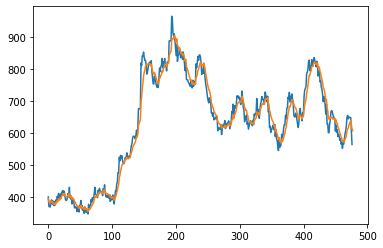

In [12]:
y = rows[:,4]
x = np.linspace(0, y.size, y.size)

yf = rowsf[:,4]
xf = np.linspace(0, yf.size, yf.size)
plt.plot(x,y, xf,yf)
plt.savefig("ma10_5_x.png")

In [28]:
rows


array([], dtype=int64)